In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import itertools
import time

from pathlib import Path
import sys

In [5]:

%load_ext autoreload
%autoreload 2
# from graph_search import random_start_graphsearch, k2_search, local_search
# from utils import get_bscor

**Q:** convert grid to index
For Python, use numpy.unravel_index and numpy.ravel_multi_index

**Q:** terminal states
For medium.csv, the simulation ends when the new position is beyond some position (where the flag is). You may want to think about which integer state measurements correspond to this case.

**Q:** What can we do when we reach a state that has no actions or reward associated with it?
You can use one of the interpolation schemes to approximate from the available states. This can be particularly possible for the medium problem, but will be difficult for the large problem because of the underlying structure.

**Q:** More info on mountain car problem? https://github.com/openai/gym/blob/master/gym/envs/classic_control/continuous_mountain_car.py

In [257]:
# set filepath, read in data
filepath = Path.cwd()
datapath = filepath / 'data'
imagepath = filepath / 'writeup/results'

## Small problem
10 x 10 grid world (100 states) with 4 actions. Actions are 1: left, 2: right, 3: up, 4: down. The discount factor is 0.95.

In [258]:
# read in data
filename = 'small'
data = pd.read_csv(datapath / f'{filename}.csv')

In [259]:
# do we have a complete dataset?
data.groupby(['s'])['a'].nunique().agg(['min', 'mean', 'max'])

# Yes! It looks like we have at least one reward for every action
# so we shouldn't need to do any gap filling!

min     4.0
mean    4.0
max     4.0
Name: a, dtype: float64

In [260]:
# get states as vectors, index to 0
n, __ = data.shape
s = data.s - 1
sp = data.sp - 1
a = data.a - 1
r = data.r
n_state, n_act = s.nunique(), a.nunique()

# define actions: left, right, up, down
a_dict = {0:-1, 1:1, 2:-10, 3:10}

# define discount
gamma = 0.95

In [261]:
# Q learning initialized to zero
Q = np.zeros((n_state, n_act))

iterations = 2
policy = np.zeros((iterations, n_state), dtype=int)

for i in range(iterations):
    # perform Q learning
    for j in range(n):
        Q[s[j], a[j]] += (1/n) * gamma * (r[j] + np.max(Q[sp[j]]) - Q[s[j], a[j]])
        
    policy[i] = np.argmax(Q, axis=1) + 1

In [262]:
# save results
with open(f'{filename}.policy', 'w') as f:
        for p in policy[-1]:
            f.write(f'{p}\n')

## Medium problem
State measurements are given by integers with 500 possible position values and 100 possible velocity values (50,000 possible state measurements). 

`1+pos+500*vel` gives the integer corresponding to a state with position pos and velocity vel. There are 7 actions that represent different amounts of acceleration. This problem is undiscounted, and ends when the goal (the flag) is reached. 

### Model-based approach (maybe for medium problem)
1. Maximum Likelihood Models with randomized updates (or full updates)
2. Bayesian methods: specify a prior over model parameters (e.g., Dirichlet)

In [436]:
# read in data
filename = 'medium'
data = pd.read_csv(datapath / f'{filename}.csv')
n_pos, n_vel, n_act = 500, 100, 7
n_state = n_pos * n_vel

In [437]:
n, __ = data.shape
s, a, r, sp = data.s-1, data.a-1, data.r, data.sp-1

In [438]:
# Q learning initialized to zero
Q = np.zeros((n_state, n_act))
U = np.zeros(n_state)

for j in range(n):
    Q[s[j], a[j]] += (1/n) * gamma * (r[j] + np.max(Q[sp[j]]) - Q[s[j], a[j]])
    
U = np.max(Q, axis=1)   

In [439]:
# get components of state variable
spos = np.mod(s, 500)
svel = ((s - spos)/500).astype(int)

sppos = np.mod(sp, 500)
spvel = ((sp - sppos)/500).astype(int)

gamma = 1.0

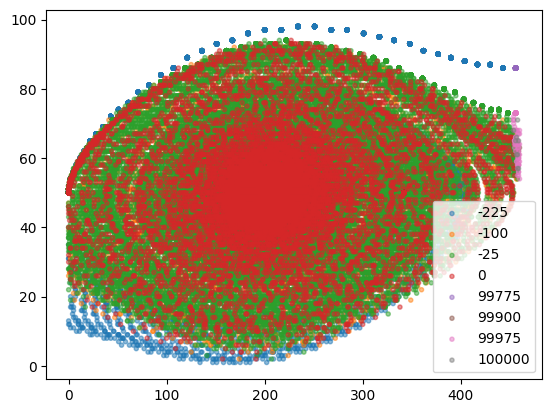

In [473]:
# Visualize
for ru in np.unique(r):
    idx = np.where(r == ru)[0]
    plt.scatter(spos[idx], svel[idx], label=ru, alpha=0.5, marker='.', linestyle='')
    
plt.legend()
plt.show()

In [ ]:
1. Nearest neighbor for the reward function

# predict transition model
# v' <- v + beta1 * a + beta2*cos(pi/200 * x)
# x' <- x + v'


# With transition model, do policy iteration

# Large problem
It’s a secret! MDP with 312020 states and 9 actions, with a discount factor of 0.95. This problem has a lot of hidden structure. Look at the transitions and rewards carefully and you might figure some of it out!

In [412]:
# read in data
filename = 'large'
data = pd.read_csv(datapath / f'{filename}.csv')

In [413]:
n, __ = data.shape
s, a, r, sp = data.s-1, data.a-1, data.r, data.sp-1
n_state, n_act = 312020, 9
gamma = 1.0

In [420]:
# Q learning initialized to zero
Q = np.zeros((n_state, n_act))
U = np.zeros(n_state)

iterations = 1
policy = np.zeros((iterations, n_state), dtype=int)

for i in range(iterations):
    # perform Q learning
    for j in range(n):
        Q[s[j], a[j]] += (1/n) * gamma * (r[j] + np.max(Q[sp[j]]) - Q[s[j], a[j]])
    
    U = np.max(Q, axis=1)   
    policy[i] = np.argmax(Q, axis=1) + 1

In [423]:
U.mean()

5.472816010657023e-07

In [419]:
Q

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [415]:
# save results
with open(f'{filename}.policy', 'w') as f:
        for p in policy[-1]:
            f.write(f'{p}\n')

In [416]:
s.nunique()

500

In [405]:
np.unique(policy[-1], return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([311648,    118,    113,    110,      6,     10,      4,      4,
             7]))

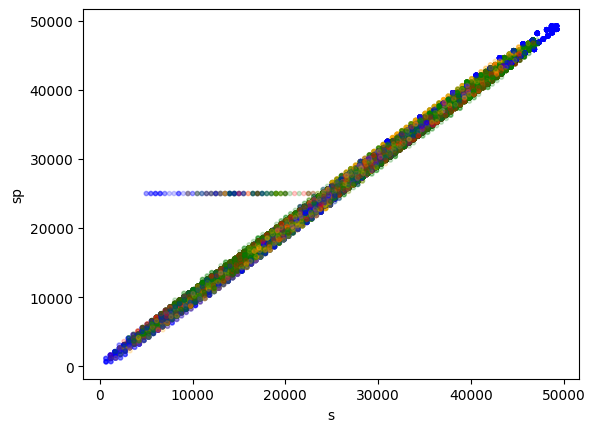

In [378]:
colors = np.array(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'yellow'], dtype=str)

r_u, r_idx = np.unique(r, return_inverse=True)
  
plt.scatter(s, sp, alpha=0.2, color=colors[r_idx], marker='.', linestyle='')

plt.xlabel('s')
plt.ylabel('sp')
plt.show()

# Appendix

### Attempt at value iteration

In [255]:
# estimate transition probabilities and reward, then value iterate
T_spsa = np.zeros((n_state, n_state, n_act))
N_sa = np.zeros((n_state, n_act))
R_sa = np.zeros((n_state, n_act))

for i in range(n):
    N_sa[s[i], a[i]] += 1
    T_spsa[sp[i], s[i], a[i]] += 1
    R_sa[s[i], a[i]] += r[i]

idx_nzero = np.where(N_sa != 0)
T_spsa /= N_sa
R_sa /= N_sa

U_s = np.zeros(n_state)

iterations = 1000
for i in range(iterations):
    for j in range(n_state):
        Qa = R_sa[j, :]
        for k in range(n_state):
            Qa += gamma * T_spsa[k, j, :]*U_s[k]
        U_s[j] = np.max(Qa)

Q_sa = R_sa + gamma * (U @ T_spsa)

p = np.argmax(Q_sa, axis=1) + 1